<a href="https://colab.research.google.com/github/Alexxxa016/AI/blob/main/datasetAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stage 1**
**Overview**

This project explores Formula 1 race data to predict drivers average lap speeds using factors like circuit length, weather, pit stops, and team. The goal is to understand what influences performance and to build a machine learning model around it.

**Sources**

Data was gathered from multiple sources.
Race and Lap Times: Kaggle.
Circuit Lengths: Manually added.
Weather Data: Open-Meteo API.

**Key Features**

Key Features Include:
lap times in ms,
circuit length,
weather,
pitstop count and constructor,
average speed.

**Statistics**

Mean average speed: 220km/h.
Lap Times range: around 70,000 ms to over 120,000 ms.
Pit stop counts: typically range from 0 to 3 per race

**Data Integration**

Data from different sources, is linked by identifying common keys or identifiers shared across datasets, For example, raceId, driverId, or circuitId.

# **Stage 2**

**Justification**

 The model is designed to predict average lap speed (km/h) for Formula 1 drivers. This target was chosen because it provides a meaningful and quantifiable measure of performance that directly reflects both driver skill and external race conditions.

 Average speed is influenced by various key factors such as circuit length, weather, pit stops, and team performance.

 By predicting average lap speed, we gain insights into how different variables contribute to performance, allowing us not only to evaluate outcomes but also to simulate scenarios. For example, using the trained model, we can create custom race scenarios—adjusting factors like temperature, humidity, and pit stop counts—to identify the optimal pit stop strategy for a given set of race conditions. This approach, demonstrated in the project, supports both performance prediction and strategic decision-making.

# **Stage 3**

Cleaning the data and linking datasets is demonstrated below.


In [ ]:
'''The code below merges race and circuit data,
 filters for 2024 races, and creates datetime columns for race start and
 a 2-hour session. It then retrieves and resamples weather data at
 15‑minute intervals for each race session using the Open-Meteo API,
 and finally saves the combined weather data to a CSV file.'''


import pandas as pd
import requests

# Load races and circuits CSVs
races_df = pd.read_csv('races.csv')
circuits_df = pd.read_csv('circuits.csv')

# Merge races with circuits to include lat and lng info used only for the weather API
races_with_circuits = races_df.merge(circuits_df[['circuitId', 'lat', 'lng']], on='circuitId', how='left')

# Filter for all races in 2024
races_2024 = races_with_circuits[races_with_circuits['year'] == 2024].copy()
print("Filtered races for 2024:")
# Display only raceId, name, date, and time
print(races_2024[['raceId', 'name', 'date', 'time']])

# Create a datetime column for the race start by combining 'date' and 'time'
races_2024['race_start_datetime'] = pd.to_datetime(races_2024['date'] + ' ' + races_2024['time'])

# session duration
session_duration = pd.Timedelta(hours=2)
races_2024['race_end_datetime'] = races_2024['race_start_datetime'] + session_duration

# Define the Open-Meteo API endpoint and  hourly parameters
weather_url = "https://archive-api.open-meteo.com/v1/archive"
hourly_params = 'temperature_2m,relativehumidity_2m,windspeed_10m,weathercode'

#  a list to store weather data for each race session
weather_data_list = []

# Loop over each race to fetch and resample weather data
for idx, race in races_2024.iterrows():
    race_date = race['date']
    # lat and lng are used only to fetch the weather data
    lat = race['lat']
    lng = race['lng']
    raceId = race['raceId']

    # Set API parameters to fetch weather for the full day
    params = {
        'latitude': lat,
        'longitude': lng,
        'start_date': race_date,
        'end_date': race_date,
        'hourly': hourly_params,
        'timezone': 'Europe/Brussels'
    }

    response = requests.get(weather_url, params=params)
    data = response.json()

    if "hourly" in data:
        df_weather = pd.DataFrame(data["hourly"])
        df_weather['time'] = pd.to_datetime(df_weather['time'])

        # Resample the data to 15-minute intervals using linear interpolation
        df_weather.set_index('time', inplace=True)
        df_weather = df_weather.resample('15min').interpolate(method='linear')
        df_weather.reset_index(inplace=True)

        # Filter weather data to only include times during the race session
        start_time = race['race_start_datetime']
        end_time = race['race_end_datetime']
        session_weather = df_weather[(df_weather['time'] >= start_time) & (df_weather['time'] <= end_time)].copy()

        # Add race-specific columns for later merging or reference
        session_weather['raceId'] = raceId
        session_weather['race_date'] = race_date

        weather_data_list.append(session_weather)
    else:
        print(f"Error retrieving weather data for raceId {raceId}: {data}")

# Combine weather data from all races and save to CSV
if weather_data_list:
    all_weather_df = pd.concat(weather_data_list, ignore_index=True)
    all_weather_df.to_csv('weather_all_races_2024_15min.csv', index=False)
    print("Weather data for all races in 2024 (session times at 15-min intervals) saved as 'weather_all_races_2024_15min.csv'.")
else:
    print("No weather data retrieved for the selected races.")


Filtered races for 2024:
      raceId                       name        date      time
1101    1121         Bahrain Grand Prix  2024-03-02  15:00:00
1102    1122   Saudi Arabian Grand Prix  2024-03-09  17:00:00
1103    1123      Australian Grand Prix  2024-03-24  04:00:00
1104    1124        Japanese Grand Prix  2024-04-07  05:00:00
1105    1125         Chinese Grand Prix  2024-04-21  07:00:00
1106    1126           Miami Grand Prix  2024-05-05  20:00:00
1107    1127  Emilia Romagna Grand Prix  2024-05-19  13:00:00
1108    1128          Monaco Grand Prix  2024-05-26  13:00:00
1109    1129        Canadian Grand Prix  2024-06-09  18:00:00
1110    1130         Spanish Grand Prix  2024-06-23  13:00:00
1111    1131        Austrian Grand Prix  2024-06-30  13:00:00
1112    1132         British Grand Prix  2024-07-07  14:00:00
1113    1133       Hungarian Grand Prix  2024-07-21  13:00:00
1114    1134         Belgian Grand Prix  2024-07-28  13:00:00
1115    1135           Dutch Grand Prix  2024

In [ ]:
'''This version is nearly identical to the previous one except
    it prints out circiutId instead of names.'''


import pandas as pd
import requests

races_df = pd.read_csv('races.csv')
circuits_df = pd.read_csv('circuits.csv')

races_with_circuits = races_df.merge(circuits_df[['circuitId', 'lat', 'lng']], on='circuitId', how='left')
races_2024 = races_with_circuits[races_with_circuits['year'] == 2024].copy()
print("Filtered races for 2024:")
print(races_2024[['raceId', 'circuitId', 'date', 'time']])
races_2024['race_start_datetime'] = pd.to_datetime(races_2024['date'] + ' ' + races_2024['time'])
session_duration = pd.Timedelta(hours=2)
races_2024['race_end_datetime'] = races_2024['race_start_datetime'] + session_duration

weather_url = "https://archive-api.open-meteo.com/v1/archive"
hourly_params = 'temperature_2m,relativehumidity_2m,windspeed_10m,weathercode'

weather_data_list = []

for idx, race in races_2024.iterrows():
    race_date = race['date']
    lat = race['lat']
    lng = race['lng']
    raceId = race['raceId']

    params = {
        'latitude': lat,
        'longitude': lng,
        'start_date': race_date,
        'end_date': race_date,
        'hourly': hourly_params,
        'timezone': 'Europe/Brussels'
    }

    response = requests.get(weather_url, params=params)
    data = response.json()

    if "hourly" in data:
        df_weather = pd.DataFrame(data["hourly"])
        df_weather['time'] = pd.to_datetime(df_weather['time'])

        df_weather.set_index('time', inplace=True)
        df_weather = df_weather.resample('15min').interpolate(method='linear')
        df_weather.reset_index(inplace=True)

        # Filter weather data to only include times during the race session
        start_time = race['race_start_datetime']
        end_time = race['race_end_datetime']
        session_weather = df_weather[(df_weather['time'] >= start_time) & (df_weather['time'] <= end_time)].copy()

        session_weather['raceId'] = raceId
        session_weather['race_date'] = race_date

        weather_data_list.append(session_weather)
    else:
        print(f"Error retrieving weather data for raceId {raceId}: {data}")

# Combine weather data from all races and save to CSV
if weather_data_list:
    all_weather_df = pd.concat(weather_data_list, ignore_index=True)
    all_weather_df.to_csv('weather_all_races_2024_15min.csv', index=False)
    print("Weather data for all races in 2024 (session times at 15-min intervals) saved as 'weather_all_races_2024_15min.csv'.")
else:
    print("No weather data retrieved for the selected races.")


Filtered races for 2024:
      raceId  circuitId        date      time
1101    1121          3  2024-03-02  15:00:00
1102    1122         77  2024-03-09  17:00:00
1103    1123          1  2024-03-24  04:00:00
1104    1124         22  2024-04-07  05:00:00
1105    1125         17  2024-04-21  07:00:00
1106    1126         79  2024-05-05  20:00:00
1107    1127         21  2024-05-19  13:00:00
1108    1128          6  2024-05-26  13:00:00
1109    1129          7  2024-06-09  18:00:00
1110    1130          4  2024-06-23  13:00:00
1111    1131         70  2024-06-30  13:00:00
1112    1132          9  2024-07-07  14:00:00
1113    1133         11  2024-07-21  13:00:00
1114    1134         13  2024-07-28  13:00:00
1115    1135         39  2024-08-25  13:00:00
1116    1136         14  2024-09-01  13:00:00
1117    1137         73  2024-09-15  11:00:00
1118    1138         15  2024-09-22  12:00:00
1119    1139         69  2024-10-20  19:00:00
1120    1140         32  2024-10-27  20:00:00
1121    1

In [ ]:
''' loads multiple CSV files (races, results, lap times, pit stops, and
constructors), filters the data to include only 2024 races, and then merges
the results with constructor information so that each record has the
corresponding constructor name. It then merges this info into both the
lap times and pit stops data, labels each record with an event type
('lap_time' or 'pit_stop'), concatenates these datasets, sorts them by
constructor and race details, and saves the combined data as a new
CSV file. '''

import pandas as pd

# Load CSV Files

races_df = pd.read_csv('races.csv')
results_df = pd.read_csv('results.csv')
lap_times_df = pd.read_csv('lap_times.csv')
pit_stops_df = pd.read_csv('pit_stops.csv')
constructors_df = pd.read_csv('constructors.csv')

#Filter for 2024 Races
races_2024 = races_df[races_df['year'] == 2024]
race_ids_2024 = races_2024['raceId'].unique()


# Map Drivers to Constructors

# Filter results to include only 2024 races.
results_2024 = results_df[results_df['raceId'].isin(race_ids_2024)]
# Merge with constructors to get constructor names.
results_2024 = results_2024.merge(
    constructors_df[['constructorId', 'name']],
    on='constructorId',
    how='left'
)
results_2024.rename(columns={'name': 'constructor'}, inplace=True)

# Merge Lap Times and Pit Stops with Constructor Info

# Filter lap_times and pit_stops to include only 2024 races.
lap_times_2024 = lap_times_df[lap_times_df['raceId'].isin(race_ids_2024)]
pit_stops_2024 = pit_stops_df[pit_stops_df['raceId'].isin(race_ids_2024)]

# Merge each with the results mapping on both raceId and driverId.
lap_times_2024 = lap_times_2024.merge(
    results_2024[['raceId', 'driverId', 'constructor']],
    on=['raceId', 'driverId'],
    how='left'
)
pit_stops_2024 = pit_stops_2024.merge(
    results_2024[['raceId', 'driverId', 'constructor']],
    on=['raceId', 'driverId'],
    how='left'
)

#  Combine and Save the Merged Data

# add an event type to distinguish records.
lap_times_2024['event_type'] = 'lap_time'
pit_stops_2024['event_type'] = 'pit_stop'

# Combine the lap times and pit stops into one DataFrame.
combined_df = pd.concat([lap_times_2024, pit_stops_2024], ignore_index=True, sort=False)

# Sort by constructor and other identifiers.
combined_df = combined_df.sort_values(['constructor', 'raceId', 'driverId']).reset_index(drop=True)

# Save the final merged data.
combined_df.to_csv('2024_season_data_grouped_by_constructor.csv', index=False)
print("Merged data for the 2024 season grouped by constructor saved as '2024_season_data_grouped_by_constructor.csv'.")


Merged data for the 2024 season grouped by constructor saved as '2024_season_data_grouped_by_constructor.csv'.


In [ ]:

#sample of the results mapping driver to constructor
print("\nSample results with constructor mapping (2024):")
print(results_2024[['raceId', 'driverId', 'constructor']])



Sample results with constructor mapping (2024):
     raceId  driverId   constructor
0      1121       830      Red Bull
1      1121       815      Red Bull
2      1121       832       Ferrari
3      1121       844       Ferrari
4      1121       847      Mercedes
..      ...       ...           ...
474    1144       825  Haas F1 Team
475    1144       859    RB F1 Team
476    1144       822        Sauber
477    1144       861      Williams
478    1144       815      Red Bull

[479 rows x 3 columns]


In [ ]:

# DataFrame grouped by constructor
print("\nCombined 2024 Season Data Grouped by Constructor:")
print(combined_df)




Combined 2024 Season Data Grouped by Constructor:
       raceId  driverId  lap  position      time  milliseconds  \
0        1121       839    1      16.0  1:46.657        106657   
1        1121       839    2      16.0  1:39.094         99094   
2        1121       839    3      16.0  1:38.771         98771   
3        1121       839    4      16.0  1:38.625         98625   
4        1121       839    5      16.0  1:38.640         98640   
...       ...       ...  ...       ...       ...           ...   
27394    1144       861   23      19.0  1:30.387         90387   
27395    1144       861   24      19.0  1:30.528         90528   
27396    1144       861   25      19.0  1:30.254         90254   
27397    1144       861   26      19.0  1:40.514        100514   
27398    1144       861    3       NaN  17:09:29         24941   

          constructor event_type  stop duration  
0      Alpine F1 Team   lap_time   NaN      NaN  
1      Alpine F1 Team   lap_time   NaN      NaN  
2     

In [ ]:
#summary count by constructor
grouped = combined_df.groupby('constructor').size().reset_index(name='record_count')
print("\nRecord Count by Constructor:")
print(grouped)



Record Count by Constructor:
      constructor  record_count
0  Alpine F1 Team          2631
1    Aston Martin          2731
2         Ferrari          2887
3    Haas F1 Team          2742
4         McLaren          2964
5        Mercedes          2853
6      RB F1 Team          2680
7        Red Bull          2738
8          Sauber          2792
9        Williams          2381


In [ ]:
# Filter for 2024 races
lap_times_2024 = lap_times_df[lap_times_df['raceId'].isin(race_ids_2024)]

# Merge with results to get constructor info
lap_times_2024 = lap_times_2024.merge(
    results_2024[['raceId', 'driverId', 'constructor']],
    on=['raceId', 'driverId'],
    how='left'
)

# Now group by constructor to count records
grouped_lap_times = lap_times_2024.groupby('constructor').size().reset_index(name='lap_time_records')
print(grouped_lap_times)


      constructor  lap_time_records
0  Alpine F1 Team              2555
1    Aston Martin              2644
2         Ferrari              2806
3    Haas F1 Team              2654
4         McLaren              2881
5        Mercedes              2769
6      RB F1 Team              2602
7        Red Bull              2653
8          Sauber              2705
9        Williams              2305


In [ ]:
pit_stops_2024 = pit_stops_df[pit_stops_df['raceId'].isin(race_ids_2024)]
pit_stops_2024 = pit_stops_2024.merge(
    results_2024[['raceId', 'driverId', 'constructor']],
    on=['raceId', 'driverId'],
    how='left'
)
grouped_pit_stops = pit_stops_2024.groupby('constructor').size().reset_index(name='pit_stop_records')
print(grouped_pit_stops)


      constructor  pit_stop_records
0  Alpine F1 Team                76
1    Aston Martin                87
2         Ferrari                81
3    Haas F1 Team                88
4         McLaren                83
5        Mercedes                84
6      RB F1 Team                78
7        Red Bull                85
8          Sauber                87
9        Williams                76


In [ ]:
# Filter results to only include finished drivers (statusId == 1)
results_2024 = results_2024[results_2024['statusId'] == 1]


In [ ]:
'''It loads several CSV files with race data and renames some time columns for clarity.
 filters the data to include only races in 2024 and keeps only the drivers
 who finished the race.'''

import pandas as pd

# Load CSV Files with Renamed Time Columns
races_df = pd.read_csv('races.csv').rename(columns={'time': 'race_time'})
results_df = pd.read_csv('results.csv')
lap_times_df = pd.read_csv('lap_times.csv').rename(columns={'time': 'laptime'})
pit_stops_df = pd.read_csv('pit_stops.csv').rename(columns={'time': 'pitstoptime'})
constructors_df = pd.read_csv('constructors.csv')

# Filter for 2024 Races
races_2024 = races_df[races_df['year'] == 2024]
race_ids_2024 = races_2024['raceId'].unique()

#Map Drivers to Constructors for Finished Races
results_2024 = results_df[results_df['raceId'].isin(race_ids_2024)]
# Keep only finished drivers (statusId == 1 means Finished)
results_2024 = results_2024[results_2024['statusId'] == 1]

# Merge with constructors to get constructor names.
results_2024 = results_2024.merge(
    constructors_df[['constructorId', 'name']],
    on='constructorId',
    how='left'
)
results_2024.rename(columns={'name': 'constructor'}, inplace=True)


#Merge Lap Times and Pit Stops with Constructor Info

# Filter lap_times and pit_stops for 2024 races.
lap_times_2024 = lap_times_df[lap_times_df['raceId'].isin(race_ids_2024)]
pit_stops_2024 = pit_stops_df[pit_stops_df['raceId'].isin(race_ids_2024)]

# Merge each with the results mapping on both raceId and driverId.
lap_times_2024 = lap_times_2024.merge(
    results_2024[['raceId', 'driverId', 'constructor']],
    on=['raceId', 'driverId'],
    how='left'
)
pit_stops_2024 = pit_stops_2024.merge(
    results_2024[['raceId', 'driverId', 'constructor']],
    on=['raceId', 'driverId'],
    how='inner'
)


#Sample Outputs

print("Finished Drivers' Lap Times (2024):")
print(lap_times_2024.head())

print("\nFinished Drivers' Pit Stops (2024):")
print(pit_stops_2024.head())


Finished Drivers' Lap Times (2024):
   raceId  driverId  lap  position   laptime  milliseconds constructor
0    1121       830    1         1  1:37.284         97284    Red Bull
1    1121       830    2         1  1:36.296         96296    Red Bull
2    1121       830    3         1  1:36.753         96753    Red Bull
3    1121       830    4         1  1:36.647         96647    Red Bull
4    1121       830    5         1  1:37.173         97173    Red Bull

Finished Drivers' Pit Stops (2024):
   raceId  driverId  stop  lap pitstoptime duration  milliseconds  \
0    1121       840     1    9    18:18:42   24.418         24418   
1    1121       847     1   11    18:21:38   24.778         24778   
2    1121       844     1   11    18:21:41   24.069         24069   
3    1121       815     1   12    18:23:16   24.516         24516   
4    1122       830     1    7    20:15:25   20.607         20607   

    constructor  
0  Aston Martin  
1      Mercedes  
2       Ferrari  
3      Red Bul

In [ ]:
'''This code first cleans the lap times data by removing an unneeded column,
renaming "milliseconds" to "lapMS", and labeling those rows as "lap_time". It then
cleans the pit stops data by converting the duration from seconds to milliseconds,
dropping an extra column, renaming columns to "pitMS" and "durationMS",
and labeling those rows as "pit_stop".
'''

# Clean Lap Times DataFrame

# Drop the string "laptime" column and rename "milliseconds" to "lapMS"
lap_times_2024_clean = lap_times_2024.drop(columns=['laptime']).rename(columns={'milliseconds': 'lapMS'})
lap_times_2024_clean['event_type'] = 'lap_time'

# Clean Pit Stops DataFrame

# Convert "duration" from seconds to milliseconds, drop the string "pitstoptime", and rename columns
pit_stops_2024_clean = pit_stops_2024.copy()
pit_stops_2024_clean['duration'] = pit_stops_2024_clean['duration'] * 1000  # Convert seconds to ms
pit_stops_2024_clean = pit_stops_2024_clean.drop(columns=['pitstoptime']).rename(
    columns={'milliseconds': 'pitMS', 'duration': 'durationMS'}
)
pit_stops_2024_clean['event_type'] = 'pit_stop'


# Merge the DataFrames
merged_df = pd.concat([lap_times_2024_clean, pit_stops_2024_clean], ignore_index=True, sort=False)
merged_df = merged_df.sort_values(['raceId', 'driverId', 'event_type']).reset_index(drop=True)

# Display the merged DataFrame
print("Merged DataFrame:")
print(merged_df.head())


Merged DataFrame:
   raceId  driverId  lap  position     lapMS constructor event_type  stop  \
0    1121         1    1       9.0  103122.0    Mercedes   lap_time   NaN   
1    1121         1    2       9.0   98273.0    Mercedes   lap_time   NaN   
2    1121         1    3       9.0   98303.0    Mercedes   lap_time   NaN   
3    1121         1    4       9.0   98287.0    Mercedes   lap_time   NaN   
4    1121         1    5       9.0   98350.0    Mercedes   lap_time   NaN   

  durationMS  pitMS  
0        NaN    NaN  
1        NaN    NaN  
2        NaN    NaN  
3        NaN    NaN  
4        NaN    NaN  


In [ ]:
'''This code loads weather and race timing data, filters and merges them by raceId,
and then groups the weather data to calculate average temperature, humidity, and
wind speed and to grab the first race date and time for each race.
It then merges these aggregated weather details with an existing merged
events DataFrame, cleans up unneeded columns and fills missing numeric values
with zero, and prints the final result.

'''

import pandas as pd

#Load and Aggregate Weather Data

# Load the weather data from the file
weather_df = pd.read_csv('weather_all_races_2024_15min.csv')

# Load race times from the races CSV
races_time = pd.read_csv('races.csv', usecols=['raceId', 'time', 'date'])
races_time = races_time.rename(columns={'time': 'race_time'})

#filter for 2024 races in races_time by raceId
races_time = races_time[races_time['raceId'].isin(weather_df['raceId'].unique())]

# Merge the race start time and date into the weather DataFrame
weather_df = pd.merge(weather_df, races_time, on='raceId', how='left')

# Group by raceId and aggregate weather metrics, taking the first race_date and race_time per race.
weather_agg = weather_df.groupby('raceId').agg({
    'temperature_2m': 'mean',
    'relativehumidity_2m': 'mean',
    'windspeed_10m': 'mean',
    'weathercode': 'first',
    'date': 'first',
    'race_time': 'first'
}).reset_index()

# Rename columns for clarity
weather_agg = weather_agg.rename(columns={
    'temperature_2m': 'avg_temp',
    'relativehumidity_2m': 'avg_humidity',
    'windspeed_10m': 'avg_windspeed',
    'date': 'race_date'
})


# Merge Weather Info with Merged Events Data
final_df = pd.merge(merged_df, weather_agg, on='raceId', how='left')

# Remove race_date and race_time columns as they were only used for weather aggregation.
final_df = final_df.drop(columns=['race_date', 'race_time'])

numeric_cols = final_df.select_dtypes(include=['number']).columns
final_df[numeric_cols] = final_df[numeric_cols].fillna(0)


# Display the final merged DataFrame
print("Final Merged DataFrame with Weather Info:")
print(final_df.head())


Final Merged DataFrame with Weather Info:
   raceId  driverId  lap  position     lapMS constructor event_type  stop  \
0    1121         1    1       9.0  103122.0    Mercedes   lap_time   0.0   
1    1121         1    2       9.0   98273.0    Mercedes   lap_time   0.0   
2    1121         1    3       9.0   98303.0    Mercedes   lap_time   0.0   
3    1121         1    4       9.0   98287.0    Mercedes   lap_time   0.0   
4    1121         1    5       9.0   98350.0    Mercedes   lap_time   0.0   

  durationMS  pitMS   avg_temp  avg_humidity  avg_windspeed  weathercode  
0        NaN    0.0  19.561111     33.555556      11.577778          3.0  
1        NaN    0.0  19.561111     33.555556      11.577778          3.0  
2        NaN    0.0  19.561111     33.555556      11.577778          3.0  
3        NaN    0.0  19.561111     33.555556      11.577778          3.0  
4        NaN    0.0  19.561111     33.555556      11.577778          3.0  


In [ ]:
'''This code converts the text columns "constructor" and "event_type" to strings
and then uses LabelEncoder to transform these categorical values into numeric labels.
Finally, it prints out the original and encoded columns so you can see the mapping'''


from sklearn.preprocessing import LabelEncoder

# Ensure the columns are of type string
final_df['constructor'] = final_df['constructor'].astype(str)
final_df['event_type'] = final_df['event_type'].astype(str)

# Encode "constructor" column
le_constructor = LabelEncoder()
final_df['constructor_encoded'] = le_constructor.fit_transform(final_df['constructor'])

# Encode "event_type" column
le_event = LabelEncoder()
final_df['event_type_encoded'] = le_event.fit_transform(final_df['event_type'])

print("Final DataFrame with Encoded 'constructor' and 'event_type':")
print(final_df[['constructor', 'constructor_encoded', 'event_type', 'event_type_encoded']].head())


Final DataFrame with Encoded 'constructor' and 'event_type':
  constructor  constructor_encoded event_type  event_type_encoded
0    Mercedes                    5   lap_time                   0
1    Mercedes                    5   lap_time                   0
2    Mercedes                    5   lap_time                   0
3    Mercedes                    5   lap_time                   0
4    Mercedes                    5   lap_time                   0


In [ ]:
print("Final DataFrame:")
print(final_df.head())


Final DataFrame:
   raceId  driverId  lap  position     lapMS constructor event_type  stop  \
0    1121         1    1       9.0  103122.0    Mercedes   lap_time   0.0   
1    1121         1    2       9.0   98273.0    Mercedes   lap_time   0.0   
2    1121         1    3       9.0   98303.0    Mercedes   lap_time   0.0   
3    1121         1    4       9.0   98287.0    Mercedes   lap_time   0.0   
4    1121         1    5       9.0   98350.0    Mercedes   lap_time   0.0   

  durationMS  pitMS   avg_temp  avg_humidity  avg_windspeed  weathercode  \
0        NaN    0.0  19.561111     33.555556      11.577778          3.0   
1        NaN    0.0  19.561111     33.555556      11.577778          3.0   
2        NaN    0.0  19.561111     33.555556      11.577778          3.0   
3        NaN    0.0  19.561111     33.555556      11.577778          3.0   
4        NaN    0.0  19.561111     33.555556      11.577778          3.0   

   constructor_encoded  event_type_encoded  
0                 

In [ ]:
unique_constructors = final_df[['constructor', 'constructor_encoded']].drop_duplicates()
print(unique_constructors)


         constructor  constructor_encoded
0           Mercedes                    5
59      Aston Martin                    1
118              nan                   10
174         Red Bull                    7
460          Ferrari                    2
749          McLaren                    4
1251    Haas F1 Team                    3
1761        Williams                    9
2897      RB F1 Team                    6
4463  Alpine F1 Team                    0
4896          Sauber                    8


In [ ]:
'''This code changes any text 'nan' in the "constructor" column to a proper
missing value, removes rows where "constructor" is missing, and then prints the
unique pairs of "constructor" and its encoded value.'''

import numpy as np

# Replace string 'nan' with actual NaN in the constructor column
final_df['constructor'] = final_df['constructor'].replace('nan', np.nan)

# Drop rows where constructor is NaN
final_df = final_df.dropna(subset=['constructor'])

# Check the unique values
print(final_df[['constructor', 'constructor_encoded']].drop_duplicates())


         constructor  constructor_encoded
0           Mercedes                    5
59      Aston Martin                    1
174         Red Bull                    7
460          Ferrari                    2
749          McLaren                    4
1251    Haas F1 Team                    3
1761        Williams                    9
2897      RB F1 Team                    6
4463  Alpine F1 Team                    0
4896          Sauber                    8


In [ ]:
print("Encoded event_type for pit_stop events:")
print(final_df[final_df['event_type'] == "pit_stop"]['event_type_encoded'].unique())

print("Encoded event_type for non-pit_stop events (lap_time):")
print(final_df[final_df['event_type'] != "pit_stop"]['event_type_encoded'].unique())


Encoded event_type for pit_stop events:
[1]
Encoded event_type for non-pit_stop events (lap_time):
[0]


In [ ]:
'''This code creates a DataFrame from a dictionary containing race IDs and
their corresponding circuit lengths. It then renames the columns to "raceId"
and "circuit_length" for consistency, and finally prints the DataFrame
displaying these two columns.
'''
import pandas as pd

# Create a DataFrame with raceId and circuit length data
data = {
    "Race ID": [1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110,
                1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120,
                1121, 1122, 1123, 1124],
    "Circuit Length (km)": [5.412, 6.174, 5.278, 5.807, 5.451, 5.412, 4.909, 3.337,
                            4.361, 4.675, 4.318, 5.891, 4.381, 7.004, 4.259, 5.793,
                            6.003, 5.063, 5.513, 4.304, 4.309, 6.120, 5.419, 5.554]
}

lengths_df = pd.DataFrame(data)

# Rename columns for consistency
lengths_df = lengths_df.rename(columns={"Race ID": "raceId", "Circuit Length (km)": "circuit_length"})

# Print the DataFrame showing only raceId and circuit_length
print("Race ID and Circuit Length:")
print(lengths_df)


Race ID and Circuit Length:
    raceId  circuit_length
0     1101           5.412
1     1102           6.174
2     1103           5.278
3     1104           5.807
4     1105           5.451
5     1106           5.412
6     1107           4.909
7     1108           3.337
8     1109           4.361
9     1110           4.675
10    1111           4.318
11    1112           5.891
12    1113           4.381
13    1114           7.004
14    1115           4.259
15    1116           5.793
16    1117           6.003
17    1118           5.063
18    1119           5.513
19    1120           4.304
20    1121           4.309
21    1122           6.120
22    1123           5.419
23    1124           5.554


In [ ]:
import pandas as pd

#Create the track length DataFrame from your provided data
data = {
    "raceId": [1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110,
               1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120,
               1121, 1122, 1123, 1124],
    "circuit_length": [5.412, 6.174, 5.278, 5.807, 5.451, 5.412, 4.909, 3.337,
                       4.361, 4.675, 4.318, 5.891, 4.381, 7.004, 4.259, 5.793,
                       6.003, 5.063, 5.513, 4.304, 4.309, 6.120, 5.419, 5.554]
}
lengths_df = pd.DataFrame(data)

#Merge track length info into your final_df on raceId
final_df_with_length = pd.merge(final_df, lengths_df, on='raceId', how='left')

# Display the final merged DataFrame
print("Final DataFrame with Circuit Length:")
print(final_df_with_length.head())


Final DataFrame with Circuit Length:
   raceId  driverId  lap  position     lapMS constructor event_type  stop  \
0    1121         1    1       9.0  103122.0    Mercedes   lap_time   0.0   
1    1121         1    2       9.0   98273.0    Mercedes   lap_time   0.0   
2    1121         1    3       9.0   98303.0    Mercedes   lap_time   0.0   
3    1121         1    4       9.0   98287.0    Mercedes   lap_time   0.0   
4    1121         1    5       9.0   98350.0    Mercedes   lap_time   0.0   

  durationMS  pitMS   avg_temp  avg_humidity  avg_windspeed  weathercode  \
0        NaN    0.0  19.561111     33.555556      11.577778          3.0   
1        NaN    0.0  19.561111     33.555556      11.577778          3.0   
2        NaN    0.0  19.561111     33.555556      11.577778          3.0   
3        NaN    0.0  19.561111     33.555556      11.577778          3.0   
4        NaN    0.0  19.561111     33.555556      11.577778          3.0   

   constructor_encoded  event_type_encoded 

In [ ]:
'''This code calculates the average speed (in km/h) for each race lap
It then saves this calculated speed in a new column called "avg_speed",
assigns it to the variable y. Finally, it displays a sample of the
average speed calculations.
'''

# Compute average speed (km/h) using circuit_length (km) and lapMS (ms)
final_df_with_length['avg_speed'] = (final_df_with_length['circuit_length'] * 3600000) / final_df_with_length['lapMS']

# y is the avg_speed column
y = final_df_with_length['avg_speed']

# Display a sample of the average speed calculations
print("Final DataFrame with Average Speed:")
print(final_df_with_length[['raceId', 'lapMS', 'circuit_length', 'avg_speed']].head())



Final DataFrame with Average Speed:
   raceId     lapMS  circuit_length   avg_speed
0    1121  103122.0           4.309  150.427649
1    1121   98273.0           4.309  157.850071
2    1121   98303.0           4.309  157.801898
3    1121   98287.0           4.309  157.827587
4    1121   98350.0           4.309  157.726487


In [ ]:
#create an interaction feature between avg_temp and circuit_length.
final_df_with_length['temp_circuit'] = final_df_with_length['avg_temp'] * final_df_with_length['circuit_length']
final_df_with_length['humidity_circuit'] = final_df_with_length['avg_humidity'] * final_df_with_length['circuit_length']
final_df_with_length['windspeed_circuit'] = final_df_with_length['avg_windspeed'] * final_df_with_length['circuit_length']

#Race Progress Feature: Remaining Laps

total_laps = 70
final_df_with_length['remaining_laps'] = total_laps - final_df_with_length['lap']

#Display a sample of the updated DataFrame
print("Final DataFrame with additional features:")
print(final_df_with_length[['raceId', 'lap', 'remaining_laps', 'circuit_length',
                             'avg_temp', 'temp_circuit', 'humidity_circuit', 'windspeed_circuit']].head())


Final DataFrame with additional features:
   raceId  lap  remaining_laps  circuit_length   avg_temp  temp_circuit  \
0    1121    1              69           4.309  19.561111     84.288828   
1    1121    2              68           4.309  19.561111     84.288828   
2    1121    3              67           4.309  19.561111     84.288828   
3    1121    4              66           4.309  19.561111     84.288828   
4    1121    5              65           4.309  19.561111     84.288828   

   humidity_circuit  windspeed_circuit  
0        144.590889          49.888644  
1        144.590889          49.888644  
2        144.590889          49.888644  
3        144.590889          49.888644  
4        144.590889          49.888644  


In [ ]:
import pandas as pd

# total number of pit stops per race and driver
pit_stop_count = pit_stops_2024_clean.groupby(['raceId', 'driverId']).size().reset_index(name='pit_stop_count')

# Merge this computed pit_stop_count into your final DataFrame based on raceId and driverId.
final_df_with_length = pd.merge(final_df_with_length, pit_stop_count, on=['raceId', 'driverId'], how='left')

# Replace any missing values for drivers with no pit stops with 0.
final_df_with_length['pit_stop_count'] = final_df_with_length['pit_stop_count'].fillna(0)

# Display a sample to verify the new column along with the original "stop" column.
print(final_df_with_length[['raceId', 'driverId', 'stop', 'pit_stop_count']].head())


   raceId  driverId  stop  pit_stop_count
0    1121         1   0.0               2
1    1121         1   0.0               2
2    1121         1   0.0               2
3    1121         1   0.0               2
4    1121         1   0.0               2


In [ ]:
'''This code calculates the average speed for each lap.
It then defines the target variable y as the computed average speed and
selects a set of features (circuit length, weather metrics, pit stop count,
and the encoded constructor) to form the input matrix x.
'''

# Compute average speed (km/h)
final_df_with_length['avg_speed'] = (final_df_with_length['circuit_length'] * 3600000) / final_df_with_length['lapMS']

# Define y as average speed
y = final_df_with_length['avg_speed']

# Define X as features (circuit_length, weather metrics, pit_stop_count, constructor_encoded)
X = final_df_with_length[['circuit_length', 'avg_temp', 'avg_humidity', 'avg_windspeed',
                          'weathercode', 'pit_stop_count', 'constructor_encoded']].copy()

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("\nSample of X:")
print(X.head())
print("\nSample of y:")
print(y.head())


Shape of X: (17437, 7)
Shape of y: (17437,)

Sample of X:
   circuit_length   avg_temp  avg_humidity  avg_windspeed  weathercode  \
0           4.309  19.561111     33.555556      11.577778          3.0   
1           4.309  19.561111     33.555556      11.577778          3.0   
2           4.309  19.561111     33.555556      11.577778          3.0   
3           4.309  19.561111     33.555556      11.577778          3.0   
4           4.309  19.561111     33.555556      11.577778          3.0   

   pit_stop_count  constructor_encoded  
0               2                    5  
1               2                    5  
2               2                    5  
3               2                    5  
4               2                    5  

Sample of y:
0    150.427649
1    157.850071
2    157.801898
3    157.827587
4    157.726487
Name: avg_speed, dtype: float64


In [ ]:
'''This code counts and prints the number of missing values (NaNs) in the
 "lapMS" and "circuit_length" columns of the final DataFrame'''

missing_lapMS = final_df_with_length['lapMS'].isnull().sum()
missing_circuit_length = final_df_with_length['circuit_length'].isnull().sum()
print("Missing lapMS:", missing_lapMS)
print("Missing circuit_length:", missing_circuit_length)


Missing lapMS: 0
Missing circuit_length: 15192


In [ ]:
''' it merges the averaged circuit lengths into the main DataFrame,
fills in missing values using manually input data or the overall mean,
and prints the final circuit lengths per race.

'''

import pandas as pd

# Track Length Data for races 1101-1124
provided_data = {
    "raceId": [1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110,
               1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120,
               1121, 1122, 1123, 1124],
    "circuit_length": [5.412, 6.174, 5.278, 5.807, 5.451, 5.412, 4.909, 3.337,
                       4.361, 4.675, 4.318, 5.891, 4.381, 7.004, 4.259, 5.793,
                       6.003, 5.063, 5.513, 4.304, 4.309, 6.120, 5.419, 5.554]
}
provided_df = pd.DataFrame(provided_data)
# Rename columns to avoid conflicts during merge
provided_df = provided_df.rename(columns={"raceId": "provided_raceId",
                                          "circuit_length": "provided_circuit_length"})

# Load Races CSV and Filter for 2024
races_df = pd.read_csv('races.csv', usecols=['raceId', 'circuitId', 'year'])
races_2024 = races_df[races_df['year'] == 2024]

# Merge the provided track lengths with the 2024 races
provided_mapping = pd.merge(provided_df, races_2024, left_on='provided_raceId', right_on='raceId', how='inner')

# Average Circuit Length per CircuitId
circuit_mapping = provided_mapping.groupby('circuitId')['provided_circuit_length'].mean().reset_index()
circuit_mapping = circuit_mapping.rename(columns={'provided_circuit_length': 'circuit_length'})

print("Circuit Mapping from Provided Data:")
print(circuit_mapping)

# Merge Circuit Mapping into 2024 Races
races_2024 = pd.merge(races_2024, circuit_mapping, on='circuitId', how='left')
print("\nFiltered 2024 Races with Circuit Lengths:")
print(races_2024[['raceId', 'circuitId', 'circuit_length']].head())

#  Merge the Circuit Lengths into Your Final DataFrame
final_df_with_length = pd.merge(final_df_with_length,
                                races_2024[['raceId', 'circuit_length']],
                                on='raceId',
                                how='left',
                                suffixes=('', '_imputed'))

# fill missing values with the imputed ones.
final_df_with_length['circuit_length'] = final_df_with_length['circuit_length'].fillna(final_df_with_length['circuit_length_imputed'])
final_df_with_length = final_df_with_length.drop(columns=['circuit_length_imputed'])

# For any remaining missing circuit lengths fill with overall mean.
overall_mean = circuit_mapping['circuit_length'].mean()
final_df_with_length['circuit_length'] = final_df_with_length['circuit_length'].fillna(overall_mean)

# Display Final Output: RaceId and Circuit Length
final_circuits = final_df_with_length[['raceId', 'circuit_length']].drop_duplicates().sort_values('raceId')
print("\nFinal DataFrame with Updated Circuit Lengths (raceId and circuit_length):")
print(final_circuits)


Circuit Mapping from Provided Data:
   circuitId  circuit_length
0          1           5.419
1          3           4.309
2         22           5.554
3         77           6.120

Filtered 2024 Races with Circuit Lengths:
   raceId  circuitId  circuit_length
0    1121          3           4.309
1    1122         77           6.120
2    1123          1           5.419
3    1124         22           5.554
4    1125         17             NaN

Final DataFrame with Updated Circuit Lengths (raceId and circuit_length):
       raceId  circuit_length
0        1121          4.3090
590      1122          6.1200
1202     1123          5.4190
1742     1124          5.5540
2245     1125          5.3505
3233     1126          5.3505
4343     1127          5.3505
4920     1128          5.3505
5475     1129          5.3505
6485     1130          5.3505
7234     1131          5.3505
8113     1132          5.3505
8762     1133          5.3505
9553     1134          5.3505
10378    1135          5.3505

In [ ]:
missing_lapMS = final_df_with_length['lapMS'].isnull().sum()
missing_circuit_length = final_df_with_length['circuit_length'].isnull().sum()
print("Missing lapMS:", missing_lapMS)
print("Missing circuit_length:", missing_circuit_length)


Missing lapMS: 0
Missing circuit_length: 0


In [ ]:
print("Number of samples:", len(final_df_with_length))


Number of samples: 17437


# **Stage 4**
**Choose and train Estimator**

The model I chose for this project was the Random Forest Regressor. This model was selected because it performs well with complex, non-linear relationships and can handle a mix of numerical and categorical features effectively.

Random Forest is especially useful in this context, as race performance is influenced by many interacting variables such as track length, weather, and team constructor and the model can capture these interactions without heavy assumptions about their linearity.

In [ ]:
'''This code first filters out rows with invalid lap times and computes the
average speed for each lap. It then creates a feature matrix and target variable,
splits the data into training and testing sets, trains a Random Forest regression
model, makes predictions on the test set, and finally evaluates the model's
performance using RMSE and cross-validation.
'''

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

#Filter out rows with invalid lapMS values zero or negative
final_df_valid = final_df_with_length[final_df_with_length['lapMS'] > 0].copy()

# average speed (km/h) using:
# avg_speed = (circuit_length * 3600000) / lapMS
final_df_valid['avg_speed'] = (final_df_valid['circuit_length'] * 3600000) / final_df_valid['lapMS']

#Define feature matrix X and target y.
# X: circuit_length, avg_temp, avg_humidity, avg_windspeed, weathercode, pit_stop_count, constructor_encoded
# y: avg_speed
X = final_df_valid[['circuit_length', 'avg_temp', 'avg_humidity',
                    'avg_windspeed', 'weathercode', 'pit_stop_count', 'constructor_encoded']]
y = final_df_valid['avg_speed']

#Split the dataset into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Create a RandomForestRegressor model.
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data.
model.fit(X_train, y_train)

# Predict on the test set.
y_pred = model.predict(X_test)

# Evaluate model performance using Mean Squared Error and RMSE.
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# perform cross-validation to assess model stability.
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("Cross-validated RMSE:", cv_rmse.mean())


Mean Squared Error: 442.82450307119785
Root Mean Squared Error: 21.04339571151001
Cross-validated RMSE: 34.4527650006781


In [ ]:
# Filter out invalid lapMS values
valid_laps_df = final_df_with_length[(final_df_with_length['lapMS'].notna()) & (final_df_with_length['lapMS'] > 0)]

# Recalculate average speed safely
valid_laps_df.loc[:, 'avg_speed'] = (valid_laps_df['circuit_length'] * 3600000) / valid_laps_df['lapMS']

# compute overall average speed
overall_avg_speed = valid_laps_df['avg_speed'].mean()
print("Cleaned Overall Average Speed (km/h):", overall_avg_speed)


Cleaned Overall Average Speed (km/h): 211.9169096650805


This Predicted vs. Actual Average Speed scatter plot shows how closely the Random Forest model's predictions align with the true values. Most points cluster around the diagonal line, indicating that the model generally predicts speeds fairly accurately in that range. However, you can see a few points are further away from the rest these are often referred to as “outliers.”

I believe the outliers in my model could arise from unexpected race conditions, such as mechanical failures, pit stop errors, or even extreme weather events that aren't common in typical laps.


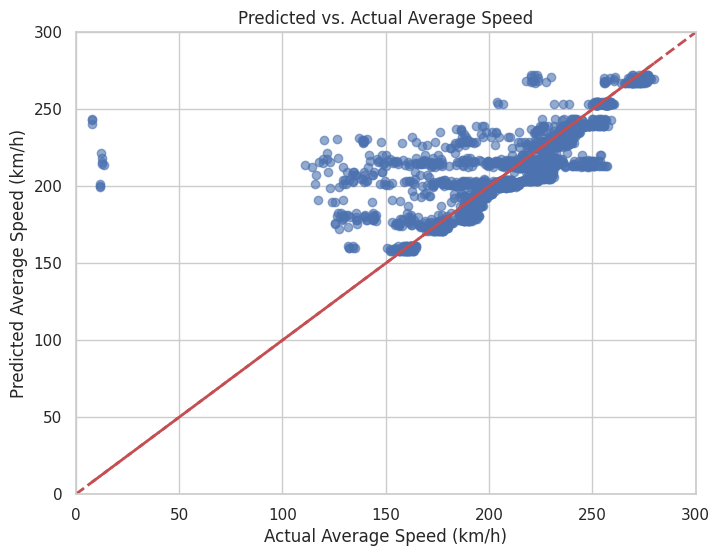

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of predicted vs. actual values.
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([0, 300], [0, 300], 'r--', lw=2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Average Speed (km/h)")
plt.ylabel("Predicted Average Speed (km/h)")
plt.title("Predicted vs. Actual Average Speed")
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.show()




# **Stage 5**
**Evaluate your model and revisit 4**

My main concern creating this pitstop scenario was misrepresenting the true impact of pit stops on race performance.In my simulation, each additional pit stop seems to automatically lead to a higher average speed, because the model captures the boost from replacing damaged tires or car parts. However, in reality, every pit stop also costs valuable time. Time during which the car isn't on track, leading to a drop in overall performance which isnt optimal.Essentially, while a pit stop can improve the car's condition and potentially increase lap speed, the lost time in the pit lane should actually lower the overall speed.




For this scenario, my simulation shows that when there are 0, 1, or 2 pit stops, the predicted average speed stays at about 270.03 km/h. However, with 3 pit stops the model predicts a slight increase to 271.28 km/h, making 3 the "optimal" pit stop count based on the model.

This result is interesting because it suggests that adding a third pit stop provides a marginal boost in lap speed, possibly due to the refreshment of the car's tires or parts—without the model accounting for the expected time loss during a pit stop.

In reality though, if you had as many as 10 pit stops, you wouldn't expect the average speed to continue increasing with each additional stop. Instead, there should be a point perhaps around 3 pit stops where the benefits of improved tire performance and car condition are balanced by the time lost in the pits. Beyond that point, extra pit stops should start to detract from overall performance and cause the average speed to drop off.


In [ ]:
'''This code simulates different race scenarios by varying the pit stop count
from 0 to 3 while keeping other conditions constant. For each scenario,
it uses your pre-trained model to predict the average speed and then prints
the predicted speeds along with the pit stop count, finally identifying the
pit stop count that gives the highest predicted average speed.
'''

import numpy as np
import pandas as pd

# Define a typical scenario.
scenario = {
    'circuit_length': 4.309,    # circuit length in km
    'avg_temp': 20.0,           # average temperature (°C)
    'avg_humidity': 40.0,       # average humidity (%)
    'avg_windspeed': 10.0,      # average windspeed (km/h)
    'weathercode': 3.0,         # weather code (encoded)
    'constructor_encoded': 5    # encoded constructor (Mercedes)
}

# Define the range of pit stop counts to simulate (0 to 4 pit stops)
pit_stop_range = np.arange(0, 4)

# List to hold simulation results: (pit_stop_count, predicted_avg_speed)
results = []

for pit_count in pit_stop_range:
    # Create a scenario with the current pit_stop_count
    scenario_features = {
        'circuit_length': scenario['circuit_length'],
        'avg_temp': scenario['avg_temp'],
        'avg_humidity': scenario['avg_humidity'],
        'avg_windspeed': scenario['avg_windspeed'],
        'weathercode': scenario['weathercode'],
        'pit_stop_count': pit_count,
        'constructor_encoded': scenario['constructor_encoded']
    }
    # Convert to DataFrame
    scenario_df = pd.DataFrame([scenario_features])
    # Predict the average speed using trained model
    predicted_speed = model.predict(scenario_df)[0]
    results.append((pit_count, predicted_speed))

# results
for pit_count, pred_speed in results:
    print(f"Pit stop count: {pit_count}, Predicted average speed: {pred_speed:.2f} km/h")

# Identify the optimal pit stop count
optimal = max(results, key=lambda x: x[1])
print(f"\nOptimal pit stop count: {optimal[0]} yields a predicted average speed of {optimal[1]:.2f} km/h")


Pit stop count: 0, Predicted average speed: 270.03 km/h
Pit stop count: 1, Predicted average speed: 270.03 km/h
Pit stop count: 2, Predicted average speed: 270.03 km/h
Pit stop count: 3, Predicted average speed: 271.28 km/h

Optimal pit stop count: 3 yields a predicted average speed of 271.28 km/h


In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (13541, 7)
y_train shape: (13541,)
X_test shape: (3386, 7)
y_test shape: (3386,)


In [ ]:
print("Number of training samples:", X_train.shape[0])
print("Number of testing samples:", X_test.shape[0])


Number of training samples: 13541
Number of testing samples: 3386


In [ ]:
'''The model filters out laps where the computed average speed is below 50 km/h
to remove any outliers. Then it selects the input features like circuit length,
weather measurements, pit stop count, and the encoded constructor and defines
the target variable as the average speed. After that, the data is split into
training and test sets, and a Random Forest Regressor is trained to predict
the average speed. Finally, the model's performance is evaluated using metrics
such as MSE, RMSE, R-squared, and cross-validation.
'''
###
#   TRAINING AND TESTING WITHOUT OUTLIERS.
###
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Filter out outliers (avg_speed < 50 km/h)

final_df_no_outliers = final_df_valid[final_df_valid['avg_speed'] >= 50].copy()


#Define X (features) and y (target)
X_no_outliers = final_df_no_outliers[['circuit_length', 'avg_temp', 'avg_humidity',
                                      'avg_windspeed', 'weathercode', 'pit_stop_count',
                                      'constructor_encoded']]
y_no_outliers = final_df_no_outliers['avg_speed']


#Split into train and test sets

X_train_no_outliers, X_test_no_outliers, y_train_no_outliers, y_test_no_outliers = train_test_split(
    X_no_outliers,
    y_no_outliers,
    test_size=0.2,
    random_state=42
)


#Fit the model and evaluate

model_no_outliers = RandomForestRegressor(n_estimators=100, random_state=42)
model_no_outliers.fit(X_train_no_outliers, y_train_no_outliers)

# Predictions
y_pred_no_outliers = model_no_outliers.predict(X_test_no_outliers)

# Calculate metrics
mse_no_outliers = mean_squared_error(y_test_no_outliers, y_pred_no_outliers)
rmse_no_outliers = np.sqrt(mse_no_outliers)
r2_no_outliers = r2_score(y_test_no_outliers, y_pred_no_outliers)

print("Filtered Model Performance (avg_speed >= 50 km/h)")
print("MSE:", mse_no_outliers)
print("RMSE:", rmse_no_outliers)
print("R-squared:", r2_no_outliers)

# Cross-validation
cv_scores_no_outliers = cross_val_score(model_no_outliers, X_no_outliers, y_no_outliers,
                                        cv=5, scoring='neg_mean_squared_error')
cv_rmse_no_outliers = np.sqrt(-cv_scores_no_outliers)
print("Cross-validated RMSE:", cv_rmse_no_outliers.mean())




Filtered Model Performance (avg_speed >= 50 km/h)
MSE: 303.0280392261555
RMSE: 17.40770057262462
R-squared: 0.6978178078163538
Cross-validated RMSE: 32.60252983028026


In this updated scatter plot, the points appear closer overall to the ideal diagonal line, indicating an improved prediction of average speed. However, some laps still fall noticeably away from the line, which could suggest various real world factors like traffic on the track that might reduce speed compared to the model's expectations.

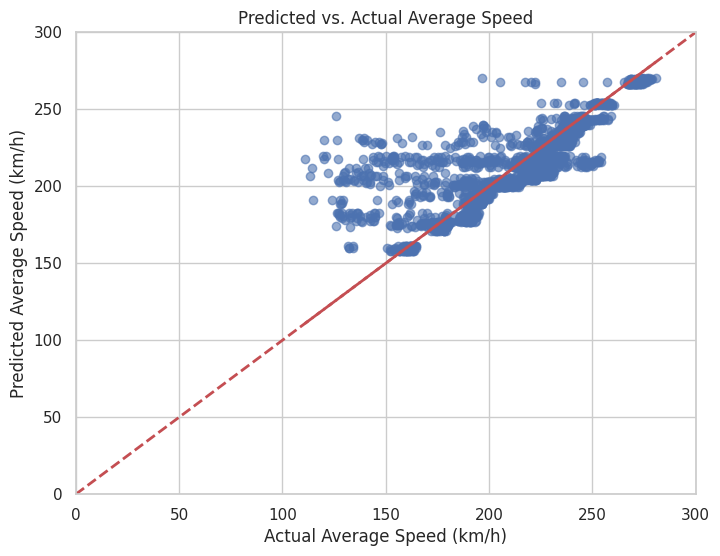

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns



# Scatter plot of predicted vs. actual values.
plt.figure(figsize=(8, 6))
plt.scatter(y_test_no_outliers, y_pred_no_outliers, alpha=0.6)
plt.plot([0, 300], [0, 300], 'r--', lw=2)
plt.plot([y_test_no_outliers.min(), y_test_no_outliers.max()], [y_test_no_outliers.min(), y_test_no_outliers.max()], 'r--', lw=2)
plt.xlabel("Actual Average Speed (km/h)")
plt.ylabel("Predicted Average Speed (km/h)")
plt.title("Predicted vs. Actual Average Speed")
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.show()




In [ ]:
print("Filtered X_train shape:", X_train_no_outliers.shape)
print("Filtered y_train shape:", y_train_no_outliers.shape)
print("Filtered X_test shape:", X_test_no_outliers.shape)
print("Filtered y_test shape:", y_test_no_outliers.shape)


Filtered X_train shape: (13516, 7)
Filtered y_train shape: (13516,)
Filtered X_test shape: (3380, 7)
Filtered y_test shape: (3380,)


In this simulation result, with 0 or 1 pit stops the predicted average speed is 235.74 km/h, and it slightly rises to 235.85 km/h with 2 pit stops. However, with 3 or 4 pit stops, the predicted speed drops back to 235.72 km/h. This indicates that the optimal number of pit stops in this scenario is 2, as that configuration produces the highest predicted average speed. This outcome also suggests that while a pit stop can improve performance by refreshing the car, too many stops start to penalize the overall speed, reflecting the natural trade-off between performance gains and time lost during pit stops.

In [ ]:

import numpy as np
import pandas as pd

# Define a new scenario for the filtered model.
new_scenario = {
    'circuit_length': 5.0,    # circuit length in km (e.g., a longer circuit)
    'avg_temp': 22.0,         # average temperature in °C
    'avg_humidity': 45.0,     # average humidity in %
    'avg_windspeed': 12.0,    # average windspeed in km/h
    'weathercode': 2.0,       # weather code (encoded; e.g., clear day)
    'constructor_encoded': 3  # encoded constructor (for example, Ferrari)
}

# Define the range of pit stop counts to simulate (from 0 to 3 pit stops)
pit_stop_range = np.arange(0, 5)

# List to hold simulation results: (pit_stop_count, predicted_avg_speed)
results = []

# Loop through each pit_stop_count, simulate the scenario, and predict average speed
for pit_count in pit_stop_range:
    # Create a scenario with the current pit_stop_count
    scenario_features = {
        'circuit_length': new_scenario['circuit_length'],
        'avg_temp': new_scenario['avg_temp'],
        'avg_humidity': new_scenario['avg_humidity'],
        'avg_windspeed': new_scenario['avg_windspeed'],
        'weathercode': new_scenario['weathercode'],
        'pit_stop_count': pit_count,
        'constructor_encoded': new_scenario['constructor_encoded']
    }

    # Convert to a DataFrame
    scenario_df = pd.DataFrame([scenario_features])

    # Predict the average speed using the filtered model
    # (make sure the filtered model was trained and stored as 'model_no_outliers')
    predicted_speed = model_no_outliers.predict(scenario_df)[0]

    results.append((pit_count, predicted_speed))

# Output the simulation results
for pit_count, pred_speed in results:
    print(f"Pit stop count: {pit_count}, Predicted average speed: {pred_speed:.2f} km/h")

# Identify the optimal pit stop count (i.e., with the highest predicted average speed)
optimal = max(results, key=lambda x: x[1])
print(f"\nOptimal pit stop count: {optimal[0]} yields a predicted average speed of {optimal[1]:.2f} km/h")


Pit stop count: 0, Predicted average speed: 235.74 km/h
Pit stop count: 1, Predicted average speed: 235.74 km/h
Pit stop count: 2, Predicted average speed: 235.85 km/h
Pit stop count: 3, Predicted average speed: 235.72 km/h
Pit stop count: 4, Predicted average speed: 235.72 km/h

Optimal pit stop count: 2 yields a predicted average speed of 235.85 km/h


In [ ]:
#Example: there were 8156 2 stop strategies
print(final_df_no_outliers['pit_stop_count'].value_counts())


pit_stop_count
2    8156
1    6543
3    1647
4     550
Name: count, dtype: int64


# **Stage 6**
**Results and Conclusions**

After training and evaluating the Random Forest Regressor, the model demonstrated reasonable performance in predicting average lap speeds based on variables such as circuit length, weather conditions, constructor, and pit stop count. By filtering out outliers like laps with unusually low speeds, the model's accuracy improved.

The scatter plot of predicted vs. actual speeds shows a positive correlation, though not all points align perfectly. Points further from the trend line may reflect real-world race events such as driver errors, traffic, or unexpected incidents.

Additionally, the model was used to simulate hypothetical race scenarios, showing how varying pit stop counts affect predicted speed. In one example, 2 pit stops yielded the highest average speed, highlighting that there's an optimal range which performance may drop. This allows for strategic planning by simulating optimal pit strategies under specific race conditions.

Conclusion:
The model offers valuable insight into how different factors impact lap speed and enables users to simulate race conditions to optimize strategies like pit stop planning. While not perfect, the results are promising and support further development with more detailed or real-time data.

Below, you can interact with the scatter plot by hovering over each point to reveal the driverId, the differences between the predictions and actual results, and the corresponding pit stop count.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import plotly.express as px

# Get test set rows from the filtered DataFrame using the indices from X_test_no_outliers
test_df = final_df_no_outliers.loc[X_test_no_outliers.index].copy()

# Add predictions and actual speeds to the DataFrame.
test_df['predicted_speed'] = y_pred_no_outliers
test_df['actual_speed'] = y_test_no_outliers

#Round speeds for display.
test_df['predicted_speed'] = test_df['predicted_speed'].round(2)
test_df['actual_speed'] = test_df['actual_speed'].round(2)

# Create an interactive scatter plot.
# 'driverId' instead of 'driver' for the hover data.
fig = px.scatter(
    test_df,
    x='actual_speed',
    y='predicted_speed',
    title="Predicted vs. Actual Average Speed (2024 Season)",
    labels={
        "actual_speed": "Actual Average Speed (km/h)",
        "predicted_speed": "Predicted Average Speed (km/h)"
    },
    range_x=[0, 300],
    range_y=[0, 300],
    hover_data={
        "driverId": True,
        "pit_stop_count": True,
        "actual_speed": True,
        "predicted_speed": True
    }
)


fig.add_shape(
    type="line",
    x0=0, y0=0, x1=300, y1=300,
    line=dict(color="red", dash="dash")
)

fig.show()


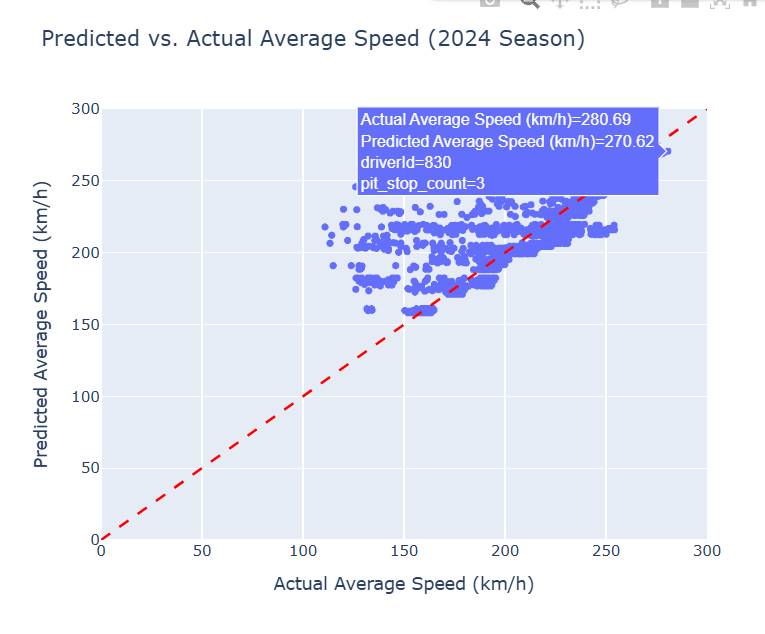

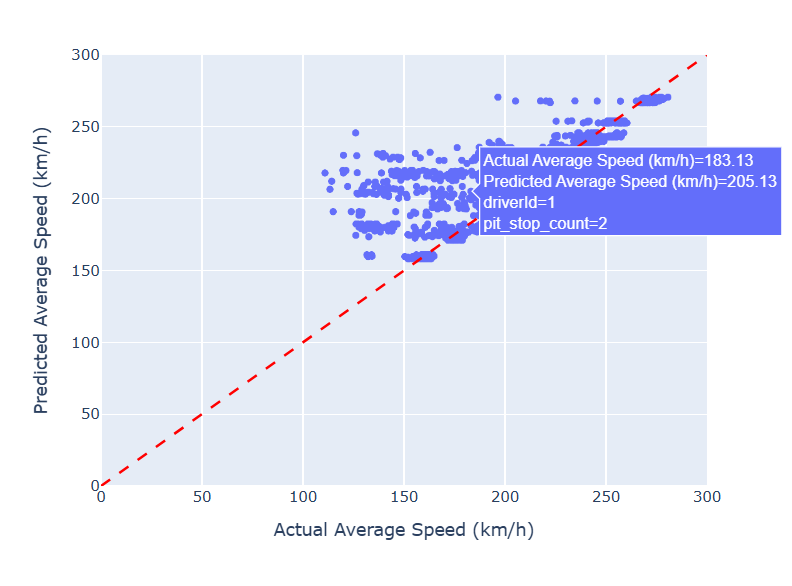